In [1]:
from numpy import all, any, array, arctan2, cos, sin, exp, dot, log, logical_and, roll, sqrt, stack, trace, unravel_index, pi, deg2rad, rad2deg, where, zeros, floor, full, nan, isnan, round, float32
from numpy.linalg import det, lstsq, norm
from cv2 import resize, GaussianBlur, subtract, KeyPoint, INTER_LINEAR, INTER_NEAREST
import cv2
from functools import cmp_to_key
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
def read_img(path):
#     read image
    img = cv2.imread(path, 0)
    display(img)
    return img.astype('float32')

def display(img):
#     display image
    plt.imshow(img, cmap= 'gray')

In [3]:
def base_generator(image, sigma, initial_sigma):
    """Generate base image from input image by upsampling by 2 in both directions and blurring
    """
    # upsampling by 2 in both directions (fx=2, fy=2)
    image = resize(image, (0, 0), fx=2, fy=2, interpolation=INTER_LINEAR)
    
    #image is assumed to be blured by a sigma of 0.5 so we blur by differnce of both sigmas (initial and wanted sigma)
    sigma_diff = (sigma ** 2) - (initial_sigma ** 2)
    
    # min blurring sigma is 0.01
    new_sigma = sqrt(max(sigma_diff, 0.01)) 
    print('old sigma: ({}), new sigma ({})'.format(2 * initial_sigma,new_sigma))
    
    # blur the upsampled image by the new calculated sigma instead of initial sigma
    gauss_image = GaussianBlur(image, (0, 0), sigmaX=new_sigma, sigmaY=new_sigma)
    
    display(gauss_image)
    
    return gauss_image 

In [4]:
def octaves_numm(border_size):
    """Compute number of octaves in image pyramid as function of base image shape (OpenCV default)
    """
    # Octaves number is the number of halving an image up to size 3*3 
    octaves_num = (log(border_size) / log(2)) -1 # the -1 is to avoid the last halving (1*1 image)
    octaves_num = int(round(octaves_num))
    
    print('The calculated number of octaves is:',octaves_num )
    
    return octaves_num

In [5]:
def kernel_sigmas(initial_sigma, intervals):
    """Generate list of sigmas at which gaussian kernels will blur the input image.
    """
    # according to the paper, we produce s+3 images in each octave  
    num_images_per_octave = intervals + 3
    
    # The initial image is incrementally convolved with Gaussians to produce images separated by a constant factor k in scale space 
    k = 2 ** (1. / intervals)
    
    # Initialize an array with the size of images in each octave to save the blurring sigma of each image in the octave
    gaussian_sigmas = zeros(num_images_per_octave)
    
    # The first image (scale) in the octave will allways hold the initial(original) sigma
    gaussian_sigmas[0] = initial_sigma

    #looping over every image in the octave starting from the second image(of index 1)
    for image_index in range(1, num_images_per_octave):
        
        sigma_previous = (k ** (image_index - 1)) * initial_sigma
        sigma_total = k * sigma_previous
        new_sigma = sqrt(sigma_total ** 2 - sigma_previous ** 2)
        gaussian_sigmas[image_index] = new_sigma
    
    gaussian_sigmas2 = array(gaussian_sigmas)
    print('The shape of the sigmas is', gaussian_sigmas2.shape)
    print('The sigmas are', gaussian_sigmas2)
    
    return gaussian_sigmas

In [6]:
def generateGaussianImages(image, num_octaves, gaussian_kernels):
    """Generate scale-space pyramid of Gaussian images
    """

    # Initialize an impty list (of lists) to carry the gausian images for all octaves
    gaussian_images = []

    # Looping over every ocatve
    for octave_index in range(num_octaves):
        
        # Initialize an impty list to carry the gausian images in every octave
        gaussian_images_in_octave = []
        
        # first image in octave already has the correct blur
        gaussian_images_in_octave.append(image) 
        
        # looping over every kernal in the same octave from the 2nd image 
        for gaussian_kernel in gaussian_kernels[1:]:
            # blur the image by the corresponding gaussian blur
            image = GaussianBlur(image, (0, 0), sigmaX=gaussian_kernel, sigmaY=gaussian_kernel)
            # Add the image to the list of the octave
            gaussian_images_in_octave.append(image)
        # Add the octave list to the list of octaves
        gaussian_images.append(gaussian_images_in_octave)
        
        # take the third-to-last image of the previous octave as the base of the next octave
        octave_base = gaussian_images_in_octave[-3]
        image = resize(octave_base, (int(octave_base.shape[1] / 2), int(octave_base.shape[0] / 2)), interpolation=INTER_NEAREST)
    
    gaussian_images = array(gaussian_images, dtype=object)
#     print(gaussian_images[0][0].shape)
    return gaussian_images

In [7]:
def DoG_images(gaussian_images):
    """Generate Difference-of-Gaussians image pyramid
    """
    # initialize a list to carry the difference of gaussians 
    dog_images = []

    # looping over each ocatve
    for gaussian_images_in_octave in gaussian_images:
        
        # initialize a list to carry the dogs of the same octave
        dog_images_in_octave = []
        # Subtract every two successive images per octave
        rng = int(len(gaussian_images_in_octave))
        
        for i in range(rng-1):
            first = gaussian_images_in_octave[i]
            second = gaussian_images_in_octave[i+1]
            # for first_image, second_image in zip(gaussian_images_in_octave, gaussian_images_in_octave[1:]):
            # ordinary subtraction will not work because the images are unsigned integers
            dog_images_in_octave.append(subtract(first, second))  
        # Add the dogs of the same octave to the dogs list    
        dog_images.append(dog_images_in_octave)
    dog_images = array(dog_images, dtype=object)
#     print(dog_images.shape)
    
    return dog_images

In [8]:
def findScaleSpaceExtrema(gaussian_images, dog_images, num_intervals, sigma, image_border_width, contrast_threshold=0.04):
    
    """Find pixel positions of all scale-space extrema in the image pyramid
    """
    threshold = floor(0.5 * contrast_threshold / num_intervals * 255)  # from OpenCV implementation
    keypoints = []

    # Looping over every octave (dogs in the same octave)
    for octave_index, dog_images_in_octave in enumerate(dog_images):
        # Taking 3 successive images to compute the extrema
        for image_index, (first_image, second_image, third_image) in enumerate(zip(dog_images_in_octave, dog_images_in_octave[1:], dog_images_in_octave[2:])):
            
            # (i, j) is the center of the 3x3 array
            for i in range(image_border_width, first_image.shape[0] - image_border_width):
                for j in range(image_border_width, first_image.shape[1] - image_border_width):
                    # since i,j are the center we send the images from (i-1 to i+2) as the three neighnour pixels 
                    
                    # sending 3 iamges of the same octave to compare the pixel with the surrounding pixels of the same, above and below image
                    if isPixelAnExtremum(first_image[i-1:i+2, j-1:j+2], second_image[i-1:i+2, j-1:j+2], third_image[i-1:i+2, j-1:j+2], threshold):

                        localization_result = quadratic_fit(i, j, image_index + 1, octave_index, num_intervals, dog_images_in_octave, sigma, contrast_threshold, image_border_width)
                        
                        if localization_result is not None:
                            keypoint, localized_image_index = localization_result
                            keypoints_with_orientations = keypoints_orientations(keypoint, octave_index, gaussian_images[octave_index][localized_image_index])
                            for keypoint_with_orientation in keypoints_with_orientations:
                                keypoints.append(keypoint_with_orientation)
    print('shape of keypoints:', array(keypoints).shape)
    return keypoints


In [9]:
def isPixelAnExtremum(first_subimage, second_subimage, third_subimage, threshold):
    """
    Compares the center pixel of the cubic pixel with all the 26 neighbours (9 of the above image, 7 of the same image, 8 of the below image)
        Return True if the center pixel is maxima compared to all its neighbors, False otherwise
    """
    # The center pixel of the center image
    center_pixel_value = second_subimage[1, 1]
    
    if abs(center_pixel_value) > threshold:
        # if the center is +ve, we need it to be greater than all the neighbours
        if center_pixel_value > 0:
            return all(center_pixel_value >= first_subimage) and \
                   all(center_pixel_value >= third_subimage) and \
                   all(center_pixel_value >= second_subimage[0, :]) and \
                   all(center_pixel_value >= second_subimage[2, :]) and \
                   center_pixel_value >= second_subimage[1, 0] and \
                   center_pixel_value >= second_subimage[1, 2]
        # if the center is -ve, we need it to be less than all the neighbours
        elif center_pixel_value < 0:
            return all(center_pixel_value <= first_subimage) and \
                   all(center_pixel_value <= third_subimage) and \
                   all(center_pixel_value <= second_subimage[0, :]) and \
                   all(center_pixel_value <= second_subimage[2, :]) and \
                   center_pixel_value <= second_subimage[1, 0] and \
                   center_pixel_value <= second_subimage[1, 2]
    return False


def gradient_comp(pixel_array):
    dx = 0.5 * (pixel_array[1, 1, 2] - pixel_array[1, 1, 0])
    dy = 0.5 * (pixel_array[1, 2, 1] - pixel_array[1, 0, 1])
    ds = 0.5 * (pixel_array[2, 1, 1] - pixel_array[0, 1, 1])
    return array([dx, dy, ds])

def hessian_comp(pixel_array):
    center_pixel_value = pixel_array[1, 1, 1]
    dxx = pixel_array[1, 1, 2] - 2 * center_pixel_value + pixel_array[1, 1, 0]
    dyy = pixel_array[1, 2, 1] - 2 * center_pixel_value + pixel_array[1, 0, 1]
    dss = pixel_array[2, 1, 1] - 2 * center_pixel_value + pixel_array[0, 1, 1]
    dxy = 0.25 * (pixel_array[1, 2, 2] - pixel_array[1, 2, 0] - pixel_array[1, 0, 2] + pixel_array[1, 0, 0])
    dxs = 0.25 * (pixel_array[2, 1, 2] - pixel_array[2, 1, 0] - pixel_array[0, 1, 2] + pixel_array[0, 1, 0])
    dys = 0.25 * (pixel_array[2, 2, 1] - pixel_array[2, 0, 1] - pixel_array[0, 2, 1] + pixel_array[0, 0, 1])
    return array([[dxx, dxy, dxs], [dxy, dyy, dys],[dxs, dys, dss]])


In [10]:
def quadratic_fit(i, j, image_index, octave_index, num_intervals, dog_images_in_octave, sigma, contrast_threshold, image_border_width, eigenvalue_ratio=10, num_attempts_until_convergence=5):
    
    extremum_is_outside_image = False
    image_shape = dog_images_in_octave[0].shape
    
    for attempt_index in range(num_attempts_until_convergence):
        # need to convert from uint8 to float32 to compute derivatives and need to rescale pixel values to [0, 1] to apply Lowe's thresholds
        first_image, second_image, third_image = dog_images_in_octave[image_index-1:image_index+2]
        pixel_cube = stack([first_image[i-1:i+2, j-1:j+2],
                            second_image[i-1:i+2, j-1:j+2],
                            third_image[i-1:i+2, j-1:j+2]]).astype('float32') / 255.
#         print('pixel_cube shape: ', pixel_cube.shape)
        
        gradient = gradient_comp(pixel_cube)
        hessian = hessian_comp(pixel_cube)
        
        extremum_update = -lstsq(hessian, gradient, rcond=None)[0]
        
        if abs(extremum_update[0]) < 0.5 and abs(extremum_update[1]) < 0.5 and abs(extremum_update[2]) < 0.5:
            break
        j += int(round(extremum_update[0]))
        i += int(round(extremum_update[1]))
        image_index += int(round(extremum_update[2]))
        
        # make sure the new pixel_cube will lie entirely within the image
        if i < image_border_width or i >= image_shape[0] - image_border_width or j < image_border_width or j >= image_shape[1] - image_border_width or image_index < 1 or image_index > num_intervals:
            extremum_is_outside_image = True
            break
    if extremum_is_outside_image:
        #logger.debug('Updated extremum moved outside of image before reaching convergence. Skipping...')
        return None
    if attempt_index >= num_attempts_until_convergence - 1:
        #
        #logger.debug('Exceeded maximum number of attempts without reaching convergence for this extremum. Skipping...')
        return None
    
    functionValueAtUpdatedExtremum = pixel_cube[1, 1, 1] + 0.5 * dot(gradient, extremum_update)
    
    if abs(functionValueAtUpdatedExtremum) * num_intervals >= contrast_threshold:
        xy_hessian = hessian[:2, :2]
        xy_hessian_trace = trace(xy_hessian)
        xy_hessian_det = det(xy_hessian)
        if xy_hessian_det > 0 and eigenvalue_ratio * (xy_hessian_trace ** 2) < ((eigenvalue_ratio + 1) ** 2) * xy_hessian_det:
            # Contrast check passed -- construct and return OpenCV KeyPoint object
            keypoint = KeyPoint()
            keypoint.pt = ((j + extremum_update[0]) * (2 ** octave_index), (i + extremum_update[1]) * (2 ** octave_index))
            keypoint.octave = octave_index + image_index * (2 ** 8) + int(round((extremum_update[2] + 0.5) * 255)) * (2 ** 16)
            keypoint.size = sigma * (2 ** ((image_index + extremum_update[2]) / float32(num_intervals))) * (2 ** (octave_index + 1))  # octave_index + 1 because the input image was doubled
            keypoint.response = abs(functionValueAtUpdatedExtremum)
            return keypoint, image_index
    return None

In [11]:
def computeKeypointsWithOrientations(keypoint, octave_index, gaussian_image, radius_factor=3, num_bins=36, peak_ratio=0.8, scale_factor=1.5):
    """Compute orientations for each keypoint
    """
#     logger.debug('Computing keypoint orientations...')
    keypoints_with_orientations = []
    image_shape = gaussian_image.shape

    scale = scale_factor * keypoint.size / float32(2 ** (octave_index + 1))  # compare with keypoint.size computation in localizeExtremumViaQuadraticFit()
    radius = int(round(radius_factor * scale))
    weight_factor = -0.5 / (scale ** 2)
    raw_histogram = zeros(num_bins)
    smooth_histogram = zeros(num_bins)

    for i in range(-radius, radius + 1):
        region_y = int(round(keypoint.pt[1] / float32(2 ** octave_index))) + i
        if region_y > 0 and region_y < image_shape[0] - 1:
            for j in range(-radius, radius + 1):
                region_x = int(round(keypoint.pt[0] / float32(2 ** octave_index))) + j
                if region_x > 0 and region_x < image_shape[1] - 1:
                    dx = gaussian_image[region_y, region_x + 1] - gaussian_image[region_y, region_x - 1]
                    dy = gaussian_image[region_y - 1, region_x] - gaussian_image[region_y + 1, region_x]
                    gradient_magnitude = sqrt(dx * dx + dy * dy)
                    gradient_orientation = rad2deg(arctan2(dy, dx))
                    weight = exp(weight_factor * (i ** 2 + j ** 2))  # constant in front of exponential can be dropped because we will find peaks later
                    histogram_index = int(round(gradient_orientation * num_bins / 360.))
                    raw_histogram[histogram_index % num_bins] += weight * gradient_magnitude

    for n in range(num_bins):
        smooth_histogram[n] = (6 * raw_histogram[n] + 4 * (raw_histogram[n - 1] + raw_histogram[(n + 1) % num_bins]) + raw_histogram[n - 2] + raw_histogram[(n + 2) % num_bins]) / 16.
    orientation_max = max(smooth_histogram)
    orientation_peaks = where(logical_and(smooth_histogram > roll(smooth_histogram, 1), smooth_histogram > roll(smooth_histogram, -1)))[0]
    for peak_index in orientation_peaks:
        peak_value = smooth_histogram[peak_index]
        if peak_value >= peak_ratio * orientation_max:
            # Quadratic peak interpolation
            # The interpolation update is given by equation (6.30) in https://ccrma.stanford.edu/~jos/sasp/Quadratic_Interpolation_Spectral_Peaks.html
            left_value = smooth_histogram[(peak_index - 1) % num_bins]
            right_value = smooth_histogram[(peak_index + 1) % num_bins]
            interpolated_peak_index = (peak_index + 0.5 * (left_value - right_value) / (left_value - 2 * peak_value + right_value)) % num_bins
            orientation = 360. - interpolated_peak_index * 360. / num_bins
            if abs(orientation - 360.) < float_tolerance:
                orientation = 0
            new_keypoint = KeyPoint(*keypoint.pt, keypoint.size, orientation, keypoint.response, keypoint.octave)
            keypoints_with_orientations.append(new_keypoint)
    return keypoints_with_orientations

In [12]:
def compare_keypoints(First_keypoint, Second_keypoint):
    """Return True if First_keypoint is less than Second_keypoint
    """
    for i in range(0,1):
        if First_keypoint.pt[i] != Second_keypoint.pt[i]:
            return First_keypoint.pt[i] - Second_keypoint.pt[i] 
        
    if First_keypoint.size != Second_keypoint.size:
        return Second_keypoint.size - First_keypoint.size
    
    if First_keypoint.angle != Second_keypoint.angle:
        return First_keypoint.angle - Second_keypoint.angle
    
    if First_keypoint.response != Second_keypoint.response:
        return Second_keypoint.response - First_keypoint.response
    
    if First_keypoint.octave != Second_keypoint.octave:
        return Second_keypoint.octave - First_keypoint.octave
    return Second_keypoint.class_id - First_keypoint.class_id


def get_unique_keypoints(keypoints):
    """Sort keypoints and remove duplicate keypoints
    """
#     if len(keypoints) < 2:
#         return keypoints

    #sorting keypoints through compare function
    keypoints.sort(key=cmp_to_key(compare_keypoints))
    
    #save first keypoint to unique_keypoints list
    unique_keypoints = [keypoints[0]]
 
    #iterating over all of the keypoints and getting the unique ones
    for current_keypoint in keypoints[1:]:
        
        previous_unique_keypoint = unique_keypoints[-1]
        
        #comparing between the previous unique point and the current point
        if (previous_unique_keypoint.pt[0] != current_keypoint.pt[0]) or \
           (previous_unique_keypoint.pt[1] != current_keypoint.pt[1]) or \
           (previous_unique_keypoint.size != current_keypoint.size) or \
           (previous_unique_keypoint.angle != current_keypoint.angle):
            unique_keypoints.append(current_keypoint)
    print('shape of unique keypoints:', array(unique_keypoints).shape)
    return unique_keypoints



def removeDuplicateKeypoints(keypoints):
    """Sort keypoints and remove duplicate keypoints
    """
    if len(keypoints) < 2:
        return keypoints

    keypoints.sort(key=cmp_to_key(compare_keypoints))
    unique_keypoints = [keypoints[0]]

    for next_keypoint in keypoints[1:]:
        last_unique_keypoint = unique_keypoints[-1]
        if last_unique_keypoint.pt[0] != next_keypoint.pt[0] or \
           last_unique_keypoint.pt[1] != next_keypoint.pt[1] or \
           last_unique_keypoint.size != next_keypoint.size or \
           last_unique_keypoint.angle != next_keypoint.angle:
            unique_keypoints.append(next_keypoint)
    print(array(unique_keypoints).shape)
    return unique_keypoints

def convertKeypointsToInputImageSize(keypoints):
    """Convert keypoint point, size, and octave to input image size
    """
    converted_keypoints = []
    for keypoint in keypoints:
        keypoint.pt = tuple(0.5 * array(keypoint.pt))
        keypoint.size *= 0.5
        keypoint.octave = (keypoint.octave & ~255) | ((keypoint.octave - 1) & 255)
        converted_keypoints.append(keypoint)
    print(array(converted_keypoints).shape)
    return converted_keypoints



In [13]:
def keypoints_orientations(keypoint, octave_index, gaussian_image, radius_factor=3, num_bins=36, peak_ratio=0.8, scale_factor=1.5):
    """
    Compute orientations for each keypoint
    The orientation histogram has 36 bins covering the 360 degree
    range of orientations
    
    """
    orientation_keypoints = []
    image_shape = gaussian_image.shape
    
    #computing standard deviation associated with the Gaussian weighting
    
    std_dev = scale_factor * keypoint.size / float32(2 ** (octave_index + 1))  # compare with keypoint.size computation in localizeExtremumViaQuadraticFit()
    
    #computing  Gaussian-weighted circular window,the neighborhood will cover pixels within 3 * scale of each keypoint,
    radius = int(round(radius_factor * std_dev))
    weight_factor = -0.5 / (std_dev ** 2)
    original_histogram = zeros(num_bins)
    blur_histogram = zeros(num_bins)

    for i in range(-radius, radius + 1):
        region_y = int(round(keypoint.pt[1] / float32(2 ** octave_index))) + i
        if region_y > 0 and region_y < image_shape[0] - 1:
            for j in range(-radius, radius + 1):
                region_x = int(round(keypoint.pt[0] / float32(2 ** octave_index))) + j
                if region_x > 0 and region_x < image_shape[1] - 1:
                    dx = gaussian_image[region_y, region_x + 1] - gaussian_image[region_y, region_x - 1]
                    dy = gaussian_image[region_y - 1, region_x] - gaussian_image[region_y + 1, region_x]
                    gradient_magnitude = sqrt(dx * dx + dy * dy)
                    gradient_orientation = rad2deg(arctan2(dy, dx))
                    weight = exp(weight_factor * (i * 2 + j * 2))  # constant in front of exponential can be dropped because we will find peaks later
                    histogram_index = int(round(gradient_orientation * num_bins / 360.))
                    original_histogram[histogram_index % num_bins] += weight * gradient_magnitude

    for n in range(num_bins):
        blur_histogram[n] = (6 * original_histogram[n] + 4 * (original_histogram[n - 1] + original_histogram[(n + 1) % num_bins]) + original_histogram[n - 2] + original_histogram[(n + 2) % num_bins]) / 16.
    orientation_max = max(blur_histogram)
    orientation_peaks = where(logical_and(blur_histogram > roll(blur_histogram, 1), blur_histogram > roll(blur_histogram, -1)))[0]
    for peak_index in orientation_peaks:
        peak_value = blur_histogram[peak_index]
        if peak_value >= peak_ratio * orientation_max:
            # Quadratic peak interpolation
            left_value = blur_histogram[(peak_index - 1) % num_bins]
            right_value = blur_histogram[(peak_index + 1) % num_bins]
            interpolated_peak_index = (peak_index + 0.5 * (left_value - right_value) / (left_value - 2 * peak_value + right_value)) % num_bins
            orientation = 360. - interpolated_peak_index * 360. / num_bins
            if abs(orientation - 360.) < float_tolerance:
                orientation = 0
            new_keypoint = KeyPoint(*keypoint.pt, keypoint.size, orientation, keypoint.response, keypoint.octave)
            orientation_keypoints.append(new_keypoint)
    return orientation_keypoints

In [14]:
#########################
# Descriptor generation #
#########################

def unpackOctave(keypoint):
    """Compute octave, layer, and scale from a keypoint
    """
    octave = keypoint.octave & 255
    layer = (keypoint.octave >> 8) & 255
    if octave >= 128:
        octave = octave | -128
    scale = 1 / float32(1 << octave) if octave >= 0 else float32(1 << -octave)
    return octave, layer, scale

def generateDescriptors(keypoints, gaussian_images, window_width=4, num_bins=8, scale_multiplier=3, descriptor_max_value=0.2):
    """Generate descriptors for each keypoint
    """
#     logger.debug('Generating descriptors...')
    descriptors = []

    for keypoint in keypoints:
        octave, layer, scale = unpackOctave(keypoint)
        gaussian_image = gaussian_images[octave + 1, layer]
        num_rows, num_cols = gaussian_image.shape
        point = round(scale * array(keypoint.pt)).astype('int')
        bins_per_degree = num_bins / 360.
        angle = 360. - keypoint.angle
        cos_angle = cos(deg2rad(angle))
        sin_angle = sin(deg2rad(angle))
        weight_multiplier = -0.5 / ((0.5 * window_width) ** 2)
        row_bin_list = []
        col_bin_list = []
        magnitude_list = []
        orientation_bin_list = []
        histogram_tensor = zeros((window_width + 2, window_width + 2, num_bins))   # first two dimensions are increased by 2 to account for border effects

        # Descriptor window size (described by half_width) follows OpenCV convention
        hist_width = scale_multiplier * 0.5 * scale * keypoint.size
        half_width = int(round(hist_width * sqrt(2) * (window_width + 1) * 0.5))   # sqrt(2) corresponds to diagonal length of a pixel
        half_width = int(min(half_width, sqrt(num_rows ** 2 + num_cols ** 2)))     # ensure half_width lies within image

        for row in range(-half_width, half_width + 1):
            for col in range(-half_width, half_width + 1):
                row_rot = col * sin_angle + row * cos_angle
                col_rot = col * cos_angle - row * sin_angle
                row_bin = (row_rot / hist_width) + 0.5 * window_width - 0.5
                col_bin = (col_rot / hist_width) + 0.5 * window_width - 0.5
                if row_bin > -1 and row_bin < window_width and col_bin > -1 and col_bin < window_width:
                    window_row = int(round(point[1] + row))
                    window_col = int(round(point[0] + col))
                    if window_row > 0 and window_row < num_rows - 1 and window_col > 0 and window_col < num_cols - 1:
                        dx = gaussian_image[window_row, window_col + 1] - gaussian_image[window_row, window_col - 1]
                        dy = gaussian_image[window_row - 1, window_col] - gaussian_image[window_row + 1, window_col]
                        gradient_magnitude = sqrt(dx * dx + dy * dy)
                        gradient_orientation = rad2deg(arctan2(dy, dx)) % 360
                        weight = exp(weight_multiplier * ((row_rot / hist_width) ** 2 + (col_rot / hist_width) ** 2))
                        row_bin_list.append(row_bin)
                        col_bin_list.append(col_bin)
                        magnitude_list.append(weight * gradient_magnitude)
                        orientation_bin_list.append((gradient_orientation - angle) * bins_per_degree)

        for row_bin, col_bin, magnitude, orientation_bin in zip(row_bin_list, col_bin_list, magnitude_list, orientation_bin_list):
            # Smoothing via trilinear interpolation
            
            # Note that we are really doing the inverse of trilinear interpolation here (we take the center value of the cube and distribute it among its eight neighbors)
            row_bin_floor, col_bin_floor, orientation_bin_floor = floor([row_bin, col_bin, orientation_bin]).astype(int)
            row_fraction, col_fraction, orientation_fraction = row_bin - row_bin_floor, col_bin - col_bin_floor, orientation_bin - orientation_bin_floor
            if orientation_bin_floor < 0:
                orientation_bin_floor += num_bins
            if orientation_bin_floor >= num_bins:
                orientation_bin_floor -= num_bins

            c1 = magnitude * row_fraction
            c0 = magnitude * (1 - row_fraction)
            c11 = c1 * col_fraction
            c10 = c1 * (1 - col_fraction)
            c01 = c0 * col_fraction
            c00 = c0 * (1 - col_fraction)
            c111 = c11 * orientation_fraction
            c110 = c11 * (1 - orientation_fraction)
            c101 = c10 * orientation_fraction
            c100 = c10 * (1 - orientation_fraction)
            c011 = c01 * orientation_fraction
            c010 = c01 * (1 - orientation_fraction)
            c001 = c00 * orientation_fraction
            c000 = c00 * (1 - orientation_fraction)

            histogram_tensor[row_bin_floor + 1, col_bin_floor + 1, orientation_bin_floor] += c000
            histogram_tensor[row_bin_floor + 1, col_bin_floor + 1, (orientation_bin_floor + 1) % num_bins] += c001
            histogram_tensor[row_bin_floor + 1, col_bin_floor + 2, orientation_bin_floor] += c010
            histogram_tensor[row_bin_floor + 1, col_bin_floor + 2, (orientation_bin_floor + 1) % num_bins] += c011
            histogram_tensor[row_bin_floor + 2, col_bin_floor + 1, orientation_bin_floor] += c100
            histogram_tensor[row_bin_floor + 2, col_bin_floor + 1, (orientation_bin_floor + 1) % num_bins] += c101
            histogram_tensor[row_bin_floor + 2, col_bin_floor + 2, orientation_bin_floor] += c110
            histogram_tensor[row_bin_floor + 2, col_bin_floor + 2, (orientation_bin_floor + 1) % num_bins] += c111

        descriptor_vector = histogram_tensor[1:-1, 1:-1, :].flatten()  # Remove histogram borders
        # Threshold and normalize descriptor_vector
        threshold = norm(descriptor_vector) * descriptor_max_value
        descriptor_vector[descriptor_vector > threshold] = threshold
        descriptor_vector /= max(norm(descriptor_vector), float_tolerance)
        # Multiply by 512, round, and saturate between 0 and 255 to convert from float32 to unsigned char (OpenCV convention)
        descriptor_vector = round(512 * descriptor_vector)
        descriptor_vector[descriptor_vector < 0] = 0
        descriptor_vector[descriptor_vector > 255] = 255
        descriptors.append(descriptor_vector)
    print('shape of descriptors is: ', array(descriptors, dtype='float32').shape)
    return array(descriptors, dtype='float32')

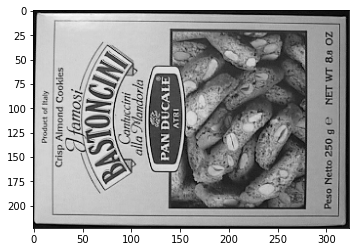

In [15]:
float_tolerance = 1e-7
path= 'box.png'
sigma=1.6
num_intervals=3
assumed_blur=1
image = read_img(path)
# image = image.astype('float32')

In [16]:
def computeKeypointsAndDescriptors(image, sigma=1.6, num_intervals=3, assumed_blur=0.5, image_border_width=5):
    image = image.astype('float32')
    base_image = base_generator(image, sigma, assumed_blur)
    num_octaves = octaves_numm(min(base_image.shape))
    gaussian_kernels = kernel_sigmas(sigma, num_intervals)
    gaussian_images = generateGaussianImages(base_image, num_octaves, gaussian_kernels)
    dog_images = DoG_images(gaussian_images)
    keypoints = findScaleSpaceExtrema(gaussian_images, dog_images, num_intervals, sigma, image_border_width)
    keypoints = get_unique_keypoints(keypoints)
    keypoints = convertKeypointsToInputImageSize(keypoints)
    descriptors = generateDescriptors(keypoints, gaussian_images)
    return keypoints, descriptors

# keys, desc = computeKeypointsAndDescriptors(image, sigma=1.6, num_intervals=3, assumed_blur=0.5, image_border_width=5)

old sigma: (1.0), new sigma (1.5198684153570665)
The calculated number of octaves is: 8
The shape of the sigmas is (6,)
The sigmas are [1.6        1.2262735  1.54500779 1.94658784 2.452547   3.09001559]
shape of keypoints: (270,)
shape of unique keypoints: (269,)
(269,)
shape of descriptors is:  (269, 128)
Computation time: 36.16465759277344


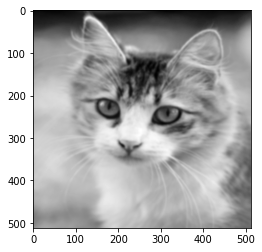

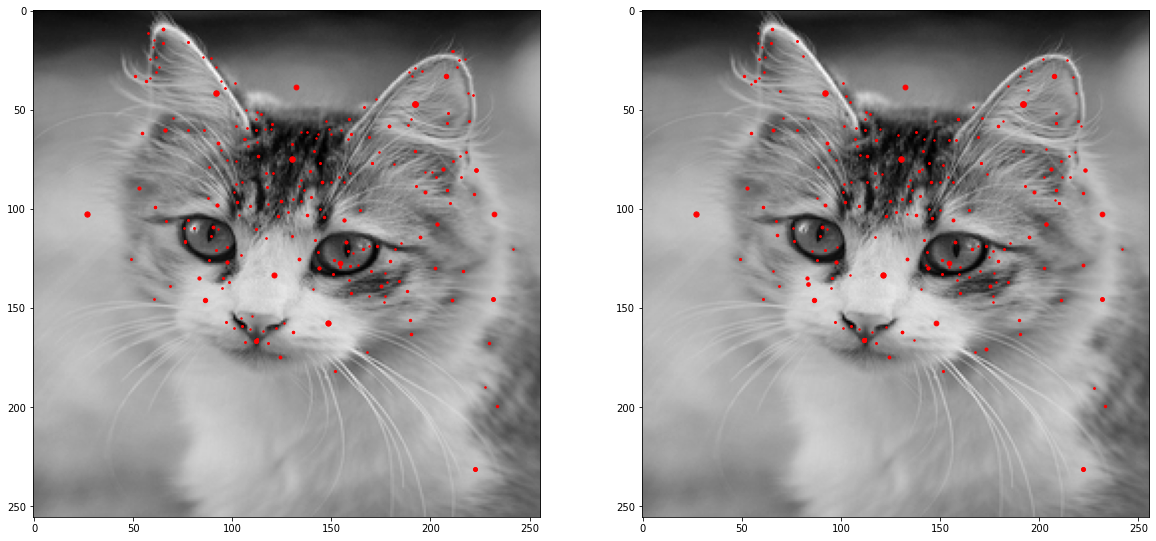

256 269


In [17]:
import time
path = 'cat256.jpg'
img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

t1 = time.time()
#     kp, dc = Sift(img)
kp, dc = computeKeypointsAndDescriptors(img, sigma=1.6, num_intervals=3, assumed_blur=0.5, image_border_width=5)
t2 = time.time()

print(f"Computation time: {t2 - t1}")

sift = cv2.SIFT_create()
kps, dcs = sift.detectAndCompute(img, None)

fig, ax = plt.subplots(1, 2, figsize=(20, 20))

ax[0].imshow(img, 'gray')
for pnt in kp:
    ax[0].scatter(pnt.pt[0], pnt.pt[1], s=pnt.size, c="red")

ax[1].imshow(img, 'gray')
for pnt in kps:
    ax[1].scatter(pnt.pt[0], pnt.pt[1], s=pnt.size, c="red")

plt.show()
print(len(kps), len(kp))

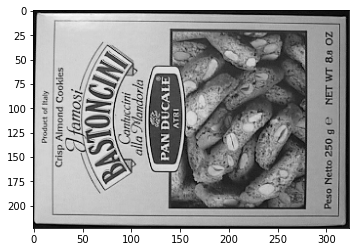

In [18]:
path= 'box.png'
sigma=1.6
num_intervals=3
assumed_blur=1
image = read_img(path)
image = image.astype('float32')

old sigma: (2), new sigma (1.2489995996796799)


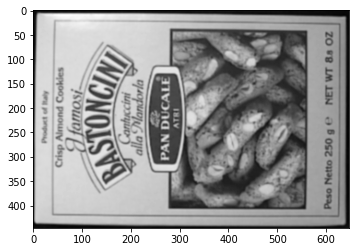

In [19]:
base_image = base_generator(image, sigma, assumed_blur)

In [20]:
octaves_num = octaves_numm(min(base_image.shape))

The calculated number of octaves is: 8


In [21]:
gaussian_kernels = kernel_sigmas(sigma, num_intervals)

The shape of the sigmas is (6,)
The sigmas are [1.6        1.2262735  1.54500779 1.94658784 2.452547   3.09001559]


In [22]:
gaussian_images = generateGaussianImages(base_image, octaves_num, gaussian_kernels)

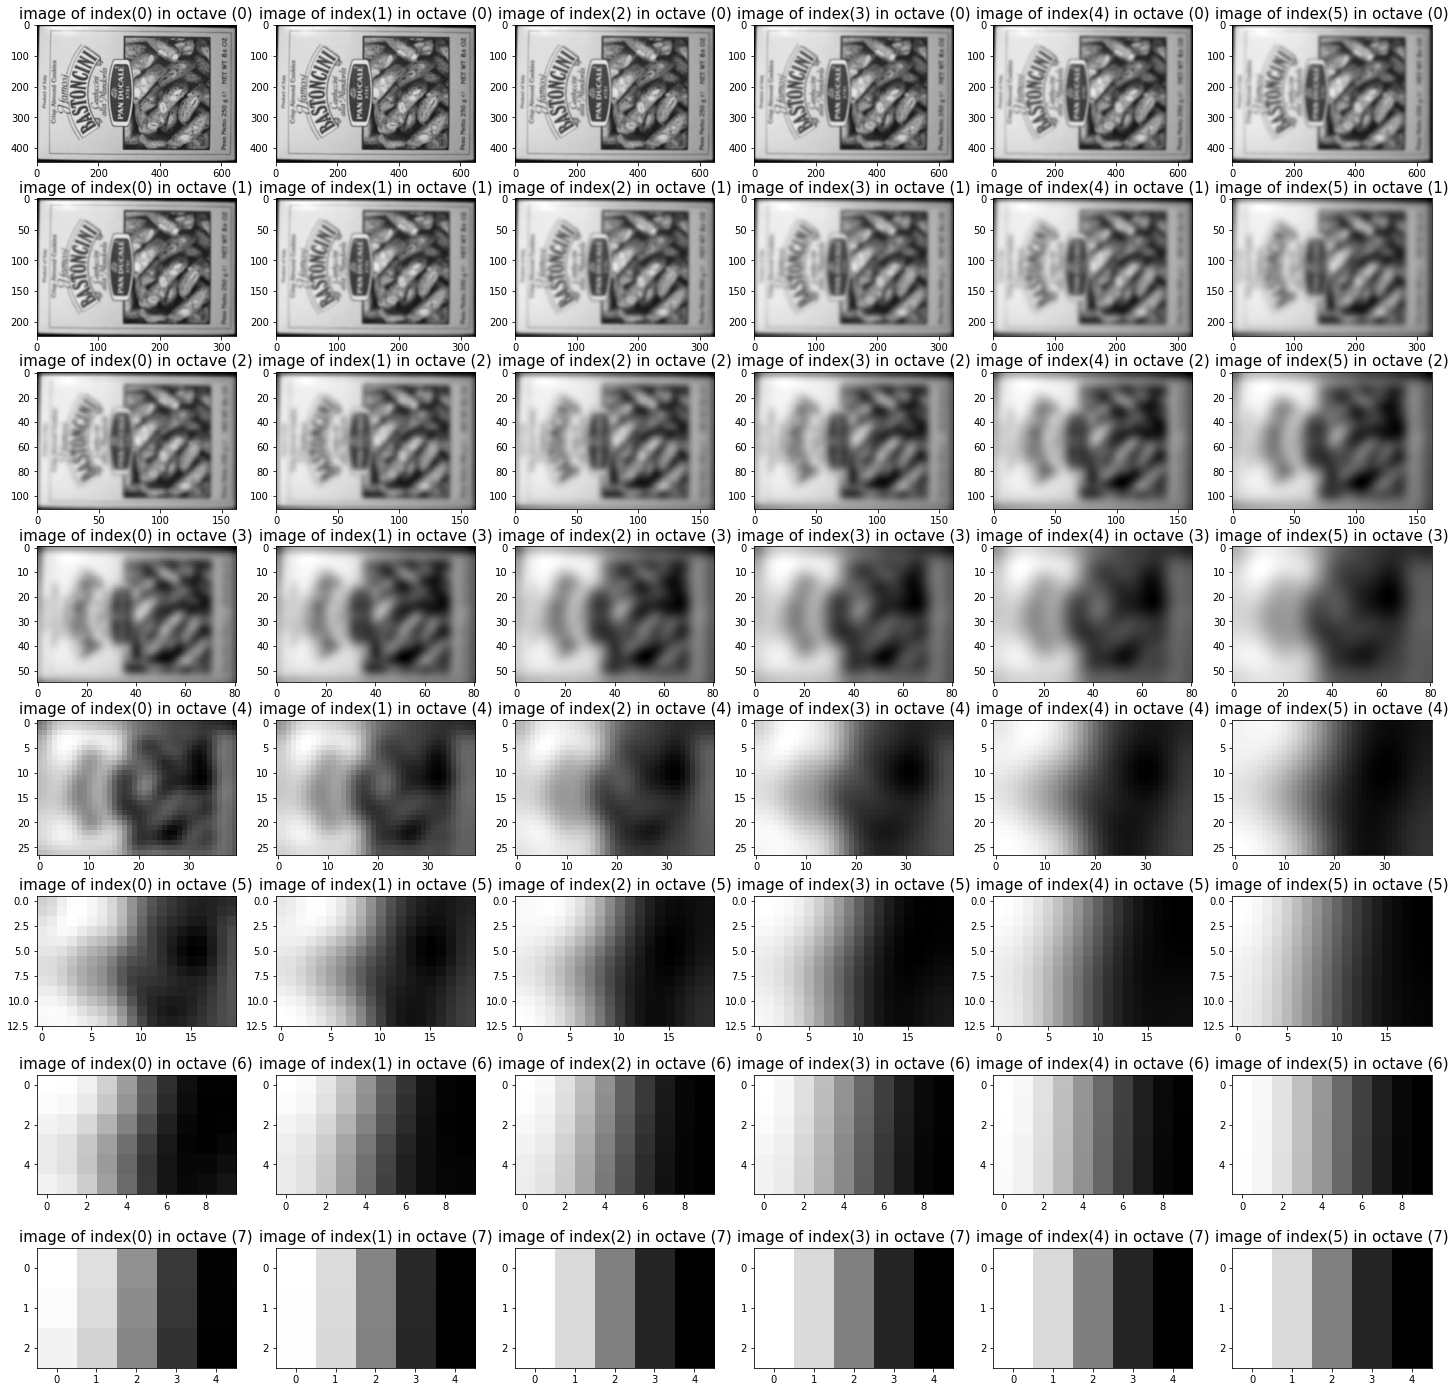

In [23]:
fig, axes = plt.subplots(gaussian_images.shape[0],gaussian_images.shape[1], figsize=(25,25))
for i in range(gaussian_images.shape[0]):
#     print('images of octave({})'.format(i))
    for j in range(gaussian_images.shape[1]):
#         print('images of index({})'.format(j))
        image = gaussian_images[i][j]
        # plot image into the subplot
        axes[i][j].imshow(image, cmap = 'gray')
        axes[i][j].set_title('image of index({}) in octave ({})'.format(j,i), size=15)

In [24]:
dog_images = DoG_images(gaussian_images)

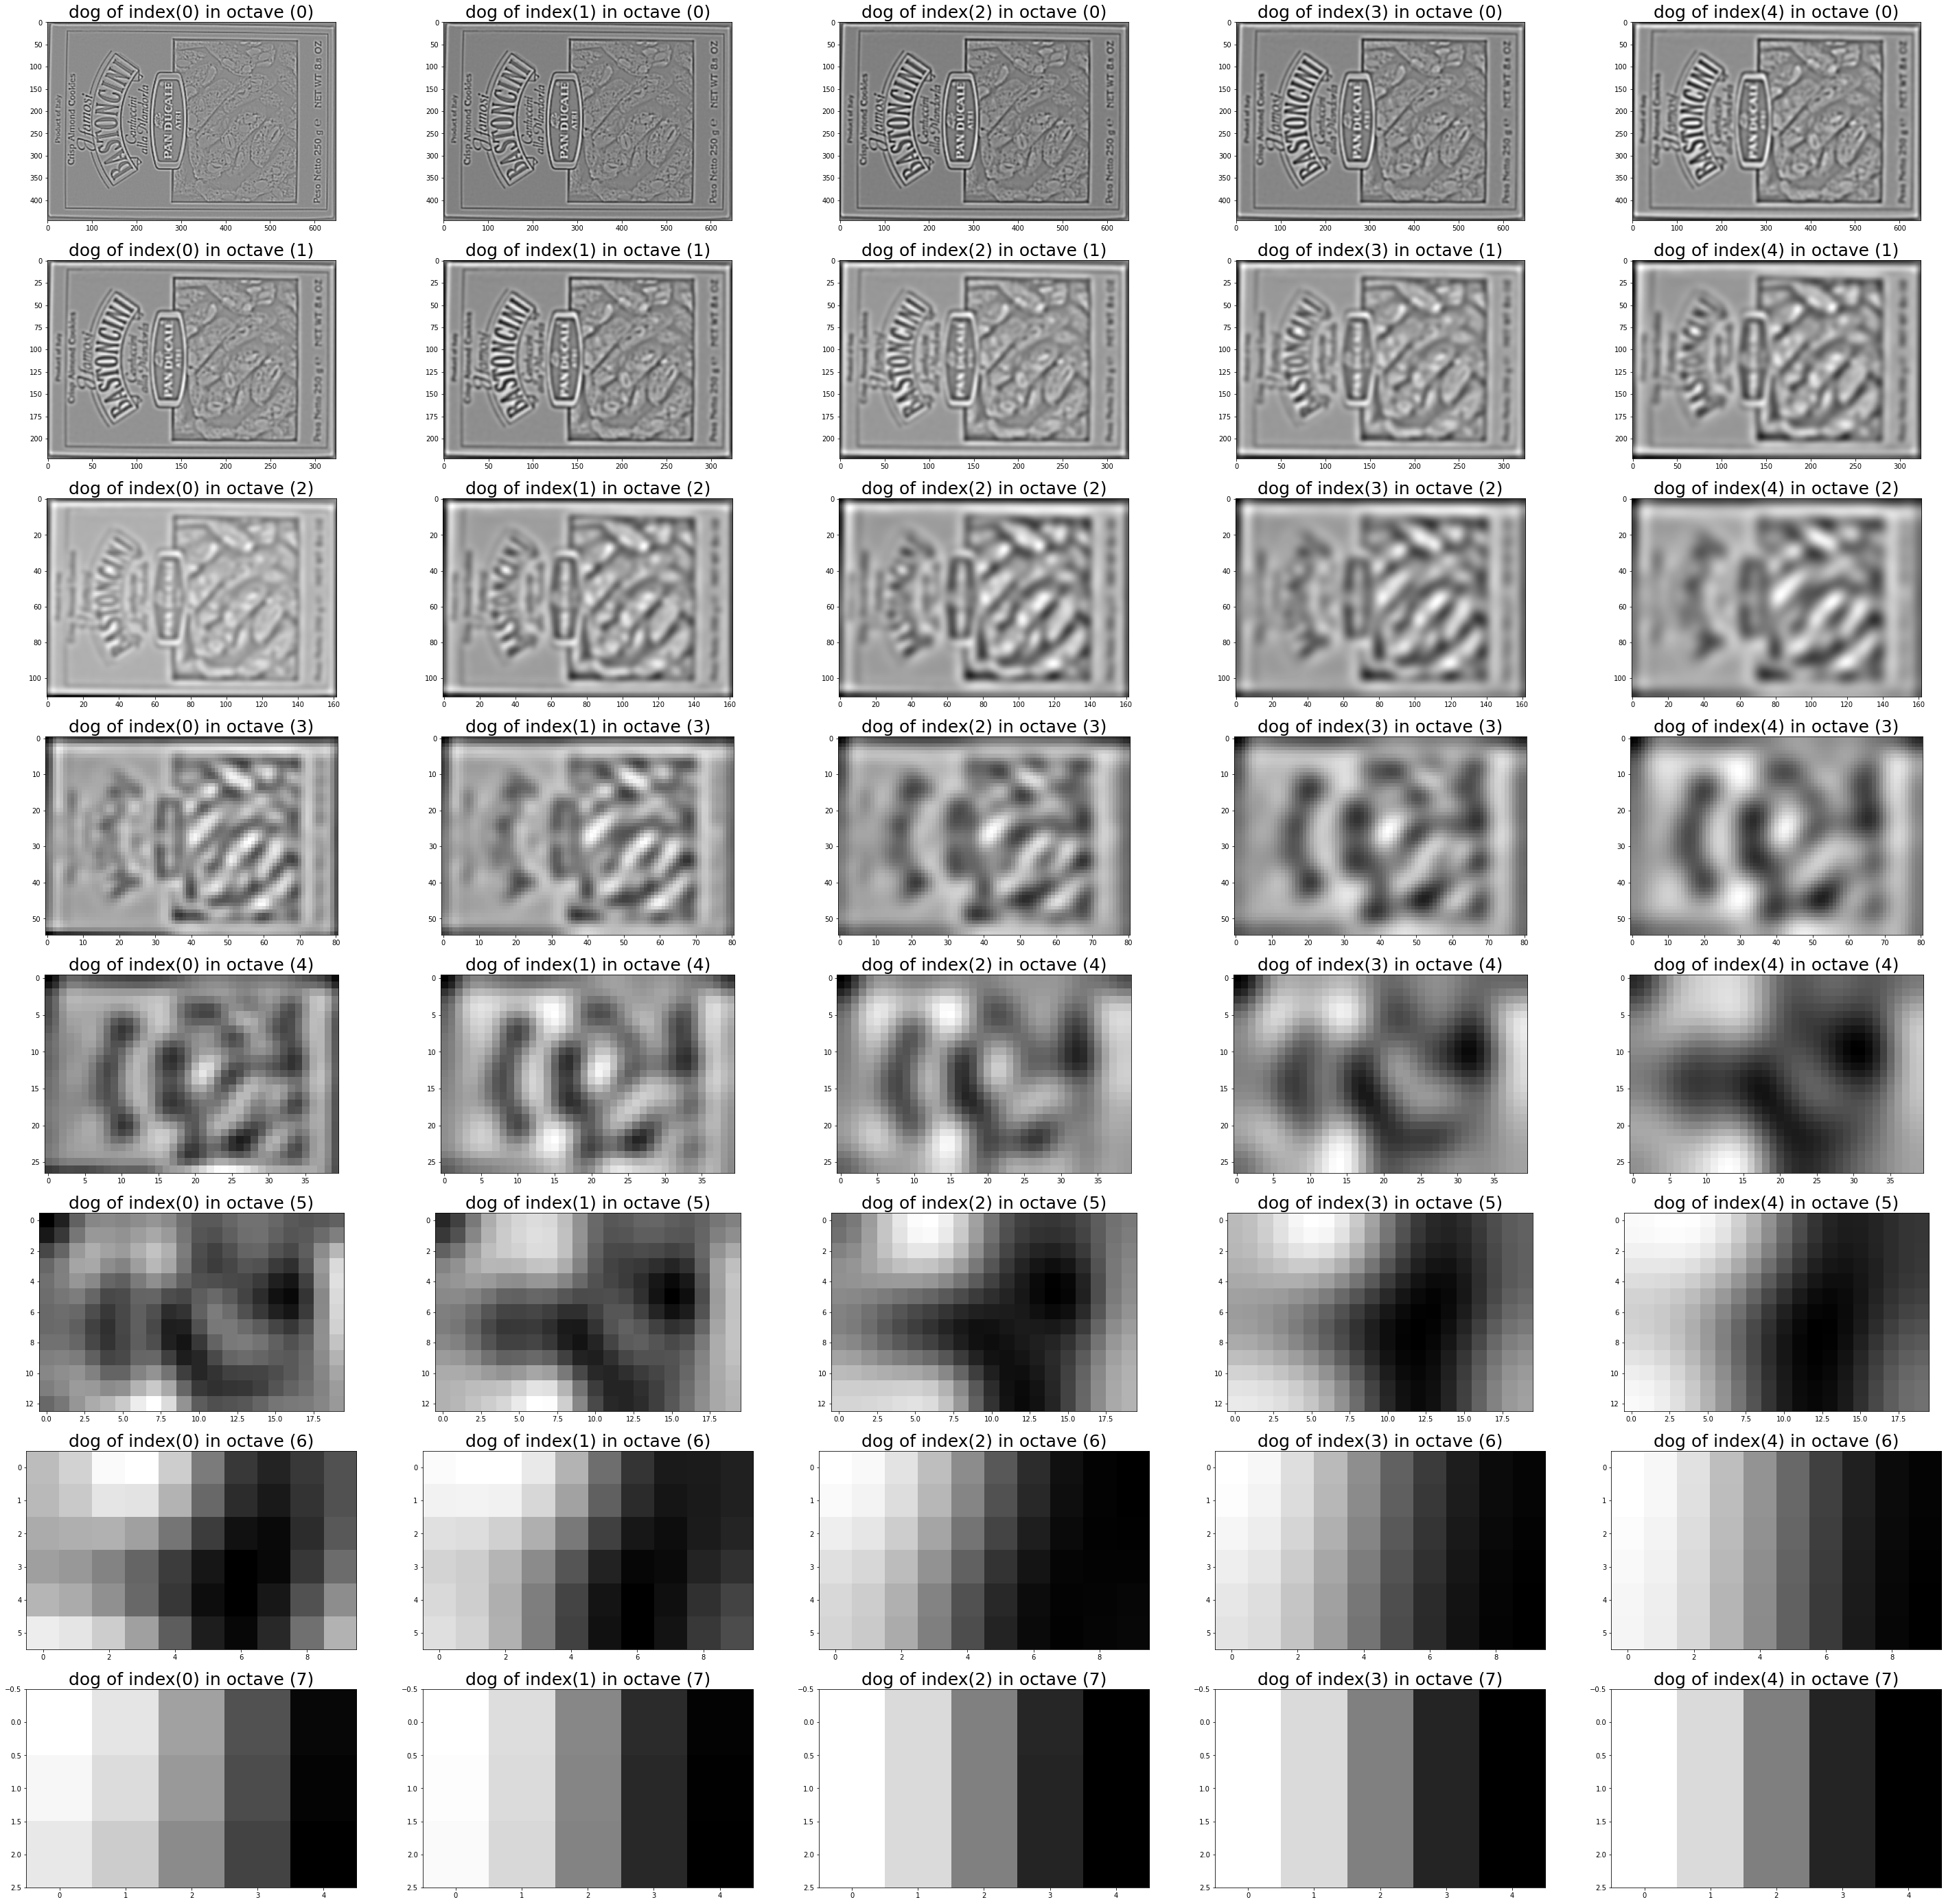

In [25]:
fig, axes = plt.subplots(dog_images.shape[0],dog_images.shape[1], figsize=(50,50))
for i in range(dog_images.shape[0]):
#     print('images of octave({})'.format(i))
    for j in range(dog_images.shape[1]):
#         print('images of index({})'.format(j))
        image = dog_images[i][j]
        # plot image into the subplot
        axes[i][j].imshow(image, cmap = 'gray')
        axes[i][j].set_title('dog of index({}) in octave ({})'.format(j,i), size=25)